# Getting started with ReColorAdv
This file contains instructions for experimenting with the ReColorAdv attack, by itself and combined with other attacks. This tutorial is based on the [first tutorial](https://github.com/revbucket/mister_ed/blob/master/notebooks/tutorial_1.ipynb) of `mister_ed`. See the README to make sure all dependencies are installed.

## Imports
First let's make sure that you can import everything you need:

In [1]:
# EXTERNAL LIBRARIES
import numpy as np 
import re

import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# mister_ed
import recoloradv.mister_ed.loss_functions as lf 
import recoloradv.mister_ed.utils.pytorch_utils as utils
import recoloradv.mister_ed.utils.image_utils as img_utils
import recoloradv.mister_ed.cifar10.cifar_loader as cifar_loader
import recoloradv.mister_ed.cifar10.cifar_resnets as cifar_resnets
import recoloradv.mister_ed.adversarial_training as advtrain
import recoloradv.mister_ed.utils.checkpoints as checkpoints
import recoloradv.mister_ed.adversarial_perturbations as ap 
import recoloradv.mister_ed.adversarial_attacks as aa
import recoloradv.mister_ed.spatial_transformers as st
import recoloradv.mister_ed.config as config

# ReColorAdv
import recoloradv.perturbations as pt
import recoloradv.color_transformers as ct
import recoloradv.color_spaces as cs
from recoloradv import norms
from recoloradv.utils import load_pretrained_cifar10_model, get_attack_from_name

In [4]:
# explanation
import sys
sys.path.append("../Spatial_transform/ST_ADV_exp_imagenet/")

from nn.utils import load_image, torch_to_image, clamp
from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, heatmap_to_image
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])

no display found. Using non-interactive Agg backend


#  Generating adversarial examples

Here, we will demonstrate how to generate a single minibatch of adversarial examples using ReColorAdv on CIFAR-10.


To set up, let's start by collecting a minibatch worth of data and loading up our classifier to attack.

In [5]:
from PIL import Image

In [6]:
im = Image.open("../Spatial_transform/ST_ADV_exp_imagenet/sample_imagenet/sample_0.jpg")
examples = torchvision.transforms.ToTensor()(
        torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(im)))
examples = examples.unsqueeze(0)
labels = torch.tensor([17])

vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=None)
# softplus model
softplus_model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=0.8)
normalizer = utils.DifferentiableNormalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])

# if utils.use_gpu():
#     examples = examples.cuda()
#     labels = labels.cuda() 
#     model.cuda()
#     softplus_model.cuda()

In [7]:
# cifar_valset = cifar_loader.load_cifar_data('val', batch_size=4)
# examples, labels = next(iter(cifar_valset))

# model, normalizer = load_pretrained_cifar10_model('pretrained_models/normal.resnet32.pt')

# if utils.use_gpu():
#     examples = examples.cuda()
#     labels = labels.cuda() 
#     model.cuda()

Let's take a look at what our original images look like:

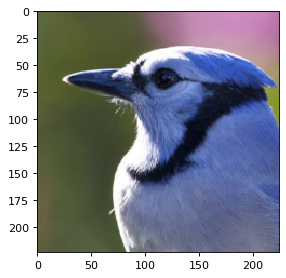

In [10]:
img_utils.show_images(examples, figsize=(4,4))

In [11]:
## expl loss
class EXPL_Loss_mse(lf.PartialLoss):
    def __init__(self, classifier, target_expl, method, normalizer=None):
        super(EXPL_Loss_mse, self).__init__()
        self.classifier = classifier
        self.target_expl = target_expl
        self.method = method
        self.normalizer = normalizer
        self.nets.append(self.classifier)


    def forward(self, examples, labels, *args, **kwargs):
        classifier_in = self.normalizer.forward(examples)
        classifier_out = self.classifier.forward(classifier_in)
        
        # get target expl
        adv_expl, _, _ = get_expl(self.classifier, classifier_in, self.method, desired_index=labels)
        loss_expl = F.mse_loss(adv_expl, self.target_expl)
        print("expl loss:", loss_expl.item())
        return loss_expl

In [12]:
## output loss
class OUTPUT_Loss_mse(lf.PartialLoss):
    def __init__(self, classifier, org_logits, normalizer=None):
        super(OUTPUT_Loss_mse, self).__init__()
        self.classifier = classifier
        self.org_logits = org_logits
        self.normalizer = normalizer
        self.nets.append(self.classifier)


    def forward(self, examples, labels, *args, **kwargs):
        classifier_in = self.normalizer.forward(examples)
        classifier_out = self.classifier.forward(classifier_in)
        
        # get target expl
        loss_output = F.mse_loss(self.classifier.classify(classifier_in)[0], self.org_logits)
        print("output loss:", loss_output.item())
        return loss_output

In [13]:
method = getattr(ExplainingMethod, "lrp")
# target expl
im = Image.open("../Spatial_transform/ST_ADV_exp_imagenet/sample_imagenet/sample_0_target.jpg")
target_examples = torchvision.transforms.ToTensor()(
        torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(im)))
target_examples = target_examples.unsqueeze(0)
# if utils.use_gpu():
#     target_examples = target_examples.cuda()

target_expl, _, _ = get_expl(model, normalizer.forward(target_examples), method)
target_expl = target_expl.detach()

In [14]:
org_logits, _ = model.classify(normalizer.forward(examples))
org_logits = org_logits.detach()

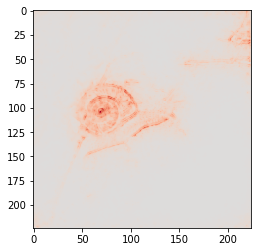

In [15]:
plt.imshow(heatmap_to_image(target_expl), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())

## ReColorAdv
Now let's attack all of these examples with a ReColorAdv attack that changes every pixel using the same function.

## Combined Attacks
Now that we've seen how to use the ReColorAdv attack, we can combine it with an additive delta attack.

In [16]:
# This threat model defines the regularization parameters of the attack.
recoloradv_threat = ap.ThreatModel(pt.ReColorAdv, {
    'xform_class': ct.FullSpatial, 
    'cspace': cs.CIELUVColorSpace(), # controls the color space used
    'lp_style': 'inf',
    'lp_bound': [0.06, 0.06, 0.06],  # [epsilon_1, epsilon_2, epsilon_3]
    'xform_params': {
      'resolution_x': 16,            # R_1
      'resolution_y': 32,            # R_2
      'resolution_z': 32,            # R_3
    },
    'use_smooth_loss': True,
})

# First, we define the additive threat model.
additive_threat = ap.ThreatModel(ap.DeltaAddition, {
   'lp_style': 'inf', 
   'lp_bound': 0.03,
})

stadv_threat = ap.ThreatModel(
                ap.ParameterizedXformAdv,
                ap.PerturbationParameters(
                    lp_style='inf',
                    lp_bound=0.05,
                    xform_class=st.FullSpatial,
                    use_stadv=True,
                ))

# Combine it with the ReColorAdv functional threat model.
combined_threat = ap.ThreatModel(
    ap.SequentialPerturbation, 
    [recoloradv_threat, stadv_threat, additive_threat],
    ap.PerturbationParameters(norm_weights=[1.0, 1.0, 0.0]),
)

# Again, define the optimization terms.
# explanation loss
expl_loss = EXPL_Loss_mse(softplus_model, target_expl, method, normalizer)

# output loss
output_loss = OUTPUT_Loss_mse(model, org_logits, normalizer)

# adv_loss = lf.CWLossF6(model, normalizer)
smooth_loss = lf.PerturbationNormLoss(lp=2)
attack_loss = lf.RegularizedLoss({'expl': expl_loss, 'out': output_loss, 'smooth': smooth_loss}, 
                                 {'expl': 1e11 ,     'out': 1e5, 'smooth': 0.05},   # lambda = 0.05
                                 negate=True) # Need this true for PGD type attacks

# Setup and run PGD over both perturbations at once.
pgd_attack_obj = aa.PGD(model, normalizer, combined_threat, attack_loss)
perturbation = pgd_attack_obj.attack(examples, labels, num_iterations=10, signed=False, 
                                     optimizer=optim.Adam, optimizer_kwargs={'lr': 0.0002},
                                     verbose=True)

# Display the successful adversarial examples.
# successful_advs, successful_origs = perturbation.collect_successful(model, normalizer)
# successful_diffs = ((successful_advs - successful_origs) * 3 + 0.5).clamp(0, 1)
# img_utils.show_images([successful_origs, successful_advs, successful_diffs])

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


(START):  100.0 correct


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

AttributeError: 'function' object has no attribute 'layer_00'

In [36]:
d = {"a": 1}
try: 
    print(d["a"])
except KeyError:
    print("error")

1


In [18]:
for k in pgd_attack_obj.loss_fxn.losses:
    l = pgd_attack_obj.loss_fxn.losses[k]
    print(k, l.forward(perturbation.adversarial_tensors(), labels, 
                      perturbation=perturbation, output_per_example=True))

expl loss: 1.2312443287143537e-09
expl tensor(1.2312e-09, device='cuda:0', grad_fn=<MseLossBackward>)
output loss: 4.3493938377096864e-13
out tensor(4.3494e-13, device='cuda:0', grad_fn=<MseLossBackward>)
smooth tensor([1199.1622], device='cuda:0', grad_fn=<AddBackward0>)


In [22]:
perturbation.layer_00.perturbation_norm(perturbation.adversarial_tensors(), 2)

tensor([1114.0765], device='cuda:0', grad_fn=<AddBackward0>)

Note that the resulting adversarial examples have been both recolored using ReColorAdv and had some additive adversarial noise applied from the delta attack.

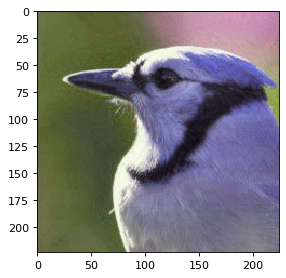

In [21]:
img_utils.show_images(perturbation.adversarial_tensors(), figsize=(4,4))

In [22]:
adv_expl,_,_ = get_expl(model, normalizer.forward(perturbation.adversarial_tensors()), method, desired_index=labels)

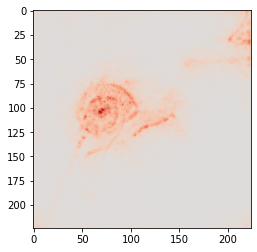

In [23]:
plt.imshow(heatmap_to_image(adv_expl), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())

In [24]:
_

tensor([17], device='cuda:0')

## Prebuilt Attacks
The convenience function `get_attack_from_name` allows you to easily instantiate one of the attacks used in the paper. For instance, to use the combined ReColorAdv, StAdv, and delta attacks:

(START):  100.0 correct
(iteration 00):  0.0 correct
(iteration 01):  0.0 correct
(iteration 02):  0.0 correct
(iteration 03):  0.0 correct
(iteration 04):  0.0 correct
(iteration 05):  0.0 correct
(iteration 06):  0.0 correct
(iteration 07):  0.0 correct
(iteration 08):  0.0 correct
(iteration 09):  0.0 correct
(iteration 10):  0.0 correct
(iteration 11):  0.0 correct
(iteration 12):  0.0 correct
(iteration 13):  0.0 correct
(iteration 14):  0.0 correct
(iteration 15):  0.0 correct
(iteration 16):  0.0 correct
(iteration 17):  0.0 correct
(iteration 18):  0.0 correct
(iteration 19):  0.0 correct
(iteration 20):  0.0 correct
(iteration 21):  0.0 correct
(iteration 22):  0.0 correct
(iteration 23):  0.0 correct
(iteration 24):  0.0 correct
(iteration 25):  0.0 correct
(iteration 26):  0.0 correct
(iteration 27):  0.0 correct
(iteration 28):  0.0 correct
(iteration 29):  0.0 correct
(iteration 30):  0.0 correct
(iteration 31):  0.0 correct
(iteration 32):  0.0 correct
(iteration 33):  0.

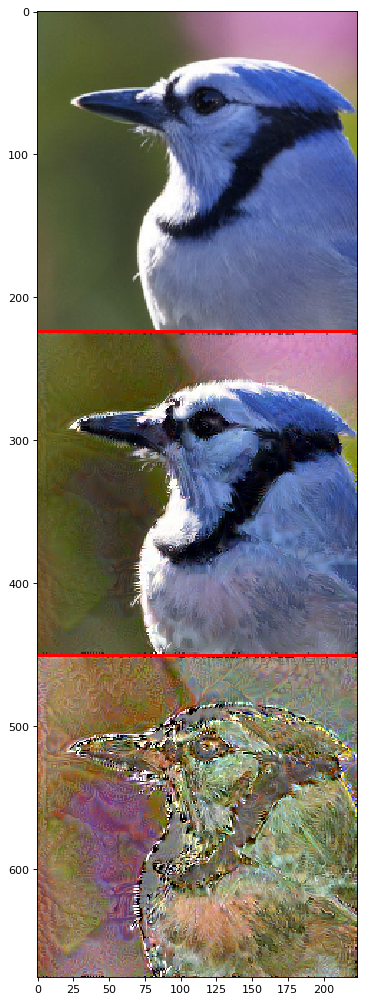

In [34]:
attack = get_attack_from_name('recoloradv+stadv+delta', model, normalizer, verbose=True)
perturbation = attack.attack(examples, labels)

# Display the successful adversarial examples.
successful_advs, successful_origs = perturbation[4].collect_successful(model, normalizer)
successful_diffs = ((successful_advs - successful_origs) * 3 + 0.5).clamp(0, 1)
img_utils.show_images([successful_origs, successful_advs, successful_diffs])

In [36]:
a = np.array([1,2,0])
((a != 1) & (a != 0)).any()

True

In [3]:
1 >= 2

False

### comparing attacks

In [16]:
softplus_model.cpu()
examples = examples.cpu()
labels = labels.cpu()
target_examples = target_examples.cpu()

In [23]:
# load the examples
x_adv_add = normalizer.forward(torch.load("output_expl/add/x_lrp.pth").cpu())
# x_adv_st = normalizer.forward(torch.load("output_expl/stadv/x_lrp.pth").cpu())
# x_adv_recolor = normalizer.forward(torch.load("output_expl/recolor/x_lrp.pth").cpu())
x_adv_add_recolor = normalizer.forward(torch.load("output_expl/add_recolor/x_lrp.pth").cpu())
x_adv_add_st = normalizer.forward(torch.load("output_expl/add_stadv/x_lrp.pth").cpu())
# x_adv_st_recolor = normalizer.forward(torch.load("output_expl/stadv_recolor/x_lrp.pth").cpu())
x_adv_add_st_recolor = normalizer.forward(torch.load("output_expl/add_stadv_recolor/x_lrp.pth").cpu())

In [27]:
expl_add = get_expl(softplus_model, x_adv_add, method, desired_index=labels)[0].cpu()
# expl_st = get_expl(softplus_model, x_adv_st, method, desired_index=labels)[0].cpu()
# expl_recolor = get_expl(softplus_model, x_adv_recolor, method, desired_index=labels)[0].cpu()
expl_add_recolor = get_expl(softplus_model, x_adv_add_recolor, method, desired_index=labels)[0].cpu()
expl_add_st = get_expl(softplus_model, x_adv_add_st, method, desired_index=labels)[0].cpu()
# expl_st_recolor = get_expl(softplus_model, x_adv_st_recolor, method, desired_index=labels)[0].cpu()
expl_add_st_recolor = get_expl(softplus_model, x_adv_add_st_recolor, method, desired_index=labels)[0].cpu()

In [28]:
org_expl = get_expl(softplus_model, normalizer.forward(examples), method, desired_index=labels)[0].cpu()
target_expl = get_expl(softplus_model, normalizer.forward(target_examples), method, desired_index=labels)[0].cpu()

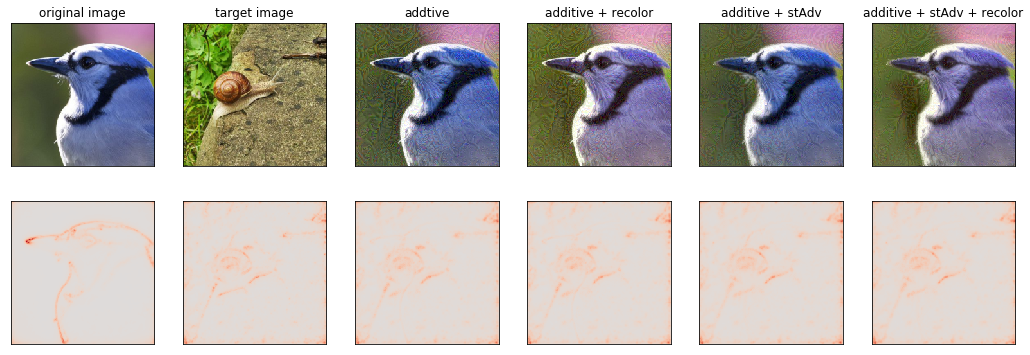

In [30]:
fig, ax = plt.subplots(2,6 , figsize=(18, 6))
ax[0, 0].imshow(torch_to_image(examples, np.array([0, 0, 0]), np.array([1, 1, 1])))
ax[0, 1].imshow(torch_to_image(target_examples, np.array([0, 0, 0]), np.array([1, 1, 1])))
ax[0, 2].imshow(torch_to_image(x_adv_add, data_mean, data_std))
# ax[0, 3].imshow(torch_to_image(x_adv_st, data_mean, data_std))
# ax[0, 4].imshow(torch_to_image(x_adv_recolor, data_mean, data_std))
ax[0, 3].imshow(torch_to_image(x_adv_add_recolor, data_mean, data_std))
ax[0, 4].imshow(torch_to_image(x_adv_add_st, data_mean, data_std))
# ax[0, 5].imshow(torch_to_image(x_adv_st_recolor, data_mean, data_std))
ax[0, 5].imshow(torch_to_image(x_adv_add_st_recolor, data_mean, data_std))
# ----
ax[1, 0].imshow(heatmap_to_image(org_expl), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())
ax[1, 1].imshow(heatmap_to_image(target_expl), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())
ax[1, 2].imshow(heatmap_to_image(expl_add), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())
# ax[1, 3].imshow(heatmap_to_image(expl_st), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())
# ax[1, 4].imshow(heatmap_to_image(expl_recolor), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())
ax[1, 3].imshow(heatmap_to_image(expl_add_recolor), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())
ax[1, 4].imshow(heatmap_to_image(expl_add_st), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())
# ax[1, 6].imshow(heatmap_to_image(expl_st_recolor), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())
ax[1, 5].imshow(heatmap_to_image(expl_add_st_recolor), cmap="coolwarm", interpolation='nearest', norm=matplotlib.colors.NoNorm())

for i in range(2):
    for j in range(6):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
# ---
ax[0, 0].set_title("original image")
ax[0, 1].set_title("target image")
ax[0, 2].set_title("addtive")
# ax[0, 3].set_title("stAdv")
# ax[0, 4].set_title("recolor")
ax[0, 3].set_title("additive + recolor")
ax[0, 4].set_title("additive + stAdv")
ax[0, 5].set_title("additive + stAdv + recolor")
plt.savefig("output_expl/all_expls.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

### SSIM

In [27]:
from recoloradv.mister_ed.utils.pytorch_ssim import ssim

In [28]:
ssim(normalizer.forward(examples), x_adv_add)

tensor(0.4062, grad_fn=<MeanBackward0>)

In [29]:
ssim(normalizer.forward(examples), x_adv_st)

tensor(0.4729, grad_fn=<MeanBackward0>)

In [30]:
ssim(normalizer.forward(examples), x_adv_recolor)

tensor(0.5620, grad_fn=<MeanBackward0>)

In [31]:
ssim(normalizer.forward(examples), x_adv_add_st)

tensor(0.4157, grad_fn=<MeanBackward0>)

In [32]:
ssim(normalizer.forward(examples), x_adv_add_st_recolor, window_size=5)

tensor(0.2875, grad_fn=<MeanBackward0>)

In [33]:
ssim(normalizer.forward(examples), x_adv_st_recolor, window_size=5)

tensor(0.4882, grad_fn=<MeanBackward0>)

In [11]:
sys.path.append("../PerceptualSimilarity/")

In [12]:
import lpips

In [14]:
loss_fn = lpips.LPIPS(net='vgg')
d = loss_fn.forward(examples.cpu(), torch.load("output_expl/add/x_lrp.pth").cpu())
print(d)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ubuntu/PerceptualSimilarity/lpips/weights/v0.1/vgg.pth
tensor([[[[0.5260]]]], grad_fn=<AddBackward0>)


In [15]:
loss_fn.forward(examples.cpu(), torch.load("output_expl/x_lrp.pth").cpu())

tensor([[[[0.3687]]]], grad_fn=<AddBackward0>)

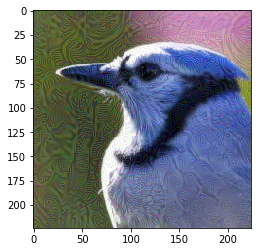

In [18]:
plt.imshow(torch_to_image(normalizer.forward(torch.load("output_expl/add/x_lrp.pth")), data_mean, data_std))

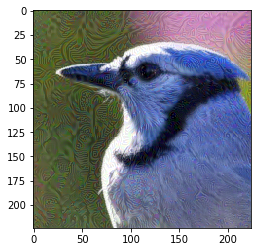

In [17]:
plt.imshow(torch_to_image(normalizer.forward(torch.load("output_expl/x_lrp.pth")), data_mean, data_std))

In [44]:
loss_fn.forward(examples, torch.load("output_expl/stadv/x_lrp.pth").cpu())

tensor([[[[0.4302]]]], grad_fn=<AddBackward0>)

In [48]:
loss_fn.forward(examples, torch.load("output_expl/recolor/x_lrp.pth").cpu())

tensor([[[[0.2730]]]], grad_fn=<AddBackward0>)

In [45]:
loss_fn.forward(examples, torch.load("output_expl/add_stadv/x_lrp.pth").cpu())

tensor([[[[0.4949]]]], grad_fn=<AddBackward0>)

In [46]:
loss_fn.forward(examples, torch.load("output_expl/stadv_recolor/x_lrp.pth").cpu())

tensor([[[[0.3700]]]], grad_fn=<AddBackward0>)

In [47]:
loss_fn.forward(examples, torch.load("output_expl/add_stadv_recolor/x_lrp.pth").cpu())

tensor([[[[0.4946]]]], grad_fn=<AddBackward0>)

#### scatter plot

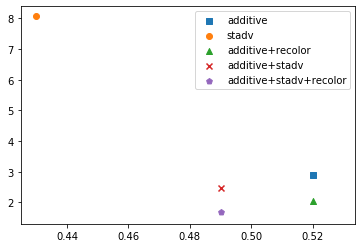

In [13]:
lpips_value = [0.52, 0.43, 0.52, 0.49, 0.49]
expl_loss_values = [2.89, 8.07, 2.04, 2.46, 1.7]
markers = ["s", "o", "^", "x", "p"]
labels = ["additive", "stadv", "additive+recolor", "additive+stadv", "additive+stadv+recolor"]
for i in range(5):
    plt.scatter(lpips_value[i], expl_loss_values[i], marker=markers[i], label=labels[i])
plt.legend()